In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import neurenorm

In [53]:
# this cell is used to quickly reload the python file
from importlib import reload
reload(neurenorm)

<module 'neurenorm' from '/Users/mr/Uni/neuronal-correlations/neurenorm.py'>

In [11]:
data = neurenorm.load_data("data.tif")

In [7]:
rdata = neurenorm.perform_renormalization(data, times = 8)

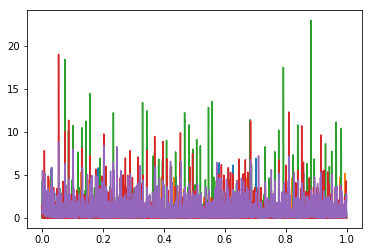

In [8]:
x = np.linspace(0, 1, len(data[0]))

for subdata in rdata[::2]:
    plt.plot(x, subdata[0])
    
plt.show()

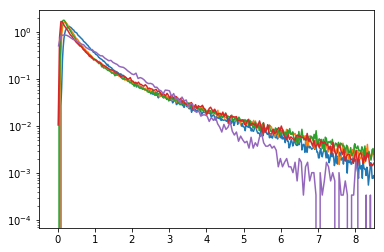

In [13]:
for subdata in rdata[::2]:
    x, y = neurenorm.make_histogram(subdata)
    plt.yscale('log')
    plt.xlim(-0.5,8.5)
    plt.plot(x, y)
plt.show()

In [54]:
p_zero, p_errs, cluster_sizes = neurenorm.renormalize_and_compute_p(data)

In [43]:
def neg_log(data):
    return -np.log(data)

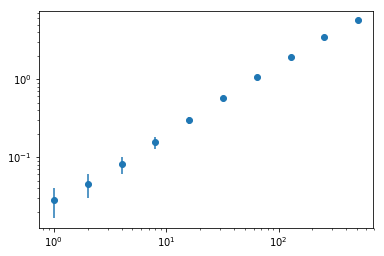

In [55]:
errs = neg_log(p_zero + p_errs / 2) - neg_log(p_zero - p_errs / 2)
plt.errorbar(cluster_sizes, neg_log(p_zero), yerr=errs, fmt='o')
plt.yscale('log')
plt.xscale('log')